In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import seaborn as sns
import cobra
import scipy.stats as st
import scipy
sys.path.append('../../code/')
import leakage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_27693/1968322243.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
folder = Path('/Users/ssulheim/Library/CloudStorage/OneDrive-UniversitédeLausanne/UNIL/leakage/experimental work/KEIO_KO_growth_test_and_exometabolome_screening_240122/exometabolome')

In [4]:
fn = folder / 'SM_MPTA_Results.xlsx'
mapping_fn = folder.parent.parent /'sintef_sept_23/exometabolome'/'met_to_bigg.csv'
od_fn = folder / '..' / 'plan_240122.xlsx'
id_mapping_fn = folder / 'id_mapping.csv'

In [5]:
mapping_dict = pd.read_csv(mapping_fn, index_col = 0).to_dict()['BiGG ID']

In [6]:
id_mapping = pd.read_csv(id_mapping_fn, index_col=0).to_dict()['OD_ID']

In [7]:
id_mapping

{'SR_MPTA_020204_11A-2_WT_22': '11A-2: WT',
 'SR_MPTA_020204_11B-2_WT_23': '11B-2: WT',
 'SR_MPTA_020204_11C-2_WT_24': '11C-2: WT',
 'SR_MPTA_020204_12A-1_pool_A_25': '12A-1: pool',
 'SR_MPTA_020204_12B-1_pool_B_26': '12B-1: pool',
 'SR_MPTA_020204_12C-1_pool_C_27': '12C-1: pool',
 'SR_MPTA_020204_1A-2_aceE_1': '1A-2: aceE',
 'SR_MPTA_020204_1B-2_aceE_2': '1B-2: aceE',
 'SR_MPTA_020204_1C-2_aceE_3': '1C-2: aceE',
 'SR_MPTA_020204_2A-2_cyoD_4': '2A-2: cyoD',
 'SR_MPTA_020204_2B-2_cyoD_5': '2B-2: cyoD',
 'SR_MPTA_020204_2C-2_cyoD_6': '2C-2: cyoD',
 'SR_MPTA_020204_3A-2_lacA_7': '3A-2: lacA',
 'SR_MPTA_020204_3B-2_lacA_8': '3B-2: lacA',
 'SR_MPTA_020204_3C-2_lacA_9': '3C-2: lacA',
 'SR_MPTA_020204_4A-2_nuoA_10': '4A-2: nuoA',
 'SR_MPTA_020204_4B-2_nuoA_11': '4B-2: nuoA',
 'SR_MPTA_020204_4C-2_nuoA_12': '4C-2: nuoA',
 'SR_MPTA_020204_5A-2_pgi_13': '5A-2: pgi',
 'SR_MPTA_020204_5B-2_pgi_14': '5B-2: pgi',
 'SR_MPTA_020204_5C-2_pgi_15': '5C-2: pgi',
 'SR_MPTA_020204_6A-2_rpe_16': '6A-2: rpe',

In [8]:
df_raw = pd.read_excel(fn, skiprows=1)
# df_raw.set_index('Unnamed: 0', inplace=True)
df_raw['Metabolite'] = [x.rstrip() for x in df_raw['Unnamed: 0']]

In [9]:
value_cols = [x for x in id_mapping.keys() if not 'pool' in x]
count_df = df_raw[['Metabolite']+value_cols]

In [10]:
df = count_df.melt(id_vars='Metabolite', value_vars=value_cols, value_name='Count', var_name='Sample ID')

In [11]:
for met in count_df.Metabolite.unique():
    try:
        mapping_dict[met]
    except KeyError:
        print(met)

PYRIMIDINE
DIHYDROURACIL
N-ACETYLLEUCINE
N-ACETYLPHENYLALANINE
4-ACETAMIDOBUTANOATE
DETHIOBIOTIN
THYMINE
NICOTINATE
BIOTIN
METHYLTHIOADENOSINE
TRYPTAMINE
ADENOSINE
TRIMETHYLAMINE
CHOLINE
TYRAMINE
AICAR
OXOPROLINE
INOSINE
METHYLGUANIDINE
KYNURENATE
RIBOFLAVIN
ANTHRANILATE
GUANINE
N-ACETYLSERINE
XANTHURENATE
N-ACETYLPUTRESCINE
ETHANOLAMINE
EPINEPHRINE
TRIGONELLINE
ADENOSINE 3', 5'-CYCLIC PHOSPHATE
4-IMIDAZOLEACETATE
N-ALPHA-ACETYLLYSINE
CYCLIC GMP
GUANIDINOSUCCINATE
S-ADENOSYLHOMOCYSTEINE
OPHTHALMATE
HISTIDINOL
CADAVERINE
PUTRESCINE
1, 3-DIAMINOPROPANE
N,N,N-TRIMETHYLLYSINE
HEXANOATE
FAD
S-ADENOSYLMETHIONINE
ARGININE
STEAROYLCARNITINE (C18)
HEXANOYLCARNITINE (C6)
CARNITINE (C0)
SALICYLATE
PYRIDOXAL
URACIL
GLYCEROL
2-OXOBUTANOATE/ACETOACETATE
GLUCURONOLACTONE
HYPOXANTHINE
2, 5-DIHYDROXYBENZOATE
2-HYDROXYBUTYRATE
ALPHA-HYDROXYISOBUTYRATE
3-(4-HYDROXYPHENYL)PYRUVATE
XANTHINE
3-HYDROXYBUTYRATE
HYDROXYPHENYLLACTATE
3-HYDROXYPHENYLACETATE
PANTOTHENATE
OROTATE
cAMP
O-ACETYLSERINE
3-HYDROXYANTHR

In [12]:
df['Sample'] = df['Sample ID'].map(id_mapping)
df['Strain'] = [x.split(': ')[1] for x in df['Sample']]

In [13]:
order_d = {'WT':0, 'lacA':1, 'aceE':2, 'cyoD':3, 'nuoA':4, 'pgi':5, 'rpe':6, 'sucB':7}

In [14]:
df.sort_values(by='Strain', key=lambda x: x.map(order_d))

,Metabolite,Sample ID,Count,Sample,Strain
0,PYRIMIDINE,SR_MPTA_020204_11A-2_WT_22,47356.347137,11A-2: WT,WT
226,4-ACETAMIDOBUTANOATE,SR_MPTA_020204_11C-2_WT_24,36854.890278,11C-2: WT,WT
225,N-ACETYLPHENYLALANINE,SR_MPTA_020204_11C-2_WT_24,4190.114510,11C-2: WT,WT
224,N-ACETYLLEUCINE,SR_MPTA_020204_11C-2_WT_24,29141.727147,11C-2: WT,WT
223,DIHYDROURACIL,SR_MPTA_020204_11C-2_WT_24,11563.144639,11C-2: WT,WT
...,...,...,...,...,...
2438,CIS-ACONITATE,SR_MPTA_020204_8A-2_sucB_19,67769.910692,8A-2: sucB,sucB
2437,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_8A-2_sucB_19,0.000087,8A-2: sucB,sucB
2436,MALATE,SR_MPTA_020204_8A-2_sucB_19,8883.267359,8A-2: sucB,sucB
2434,SUCCINATE,SR_MPTA_020204_8A-2_sucB_19,1734.432309,8A-2: sucB,sucB


In [41]:
df.loc[df.Metabolite == 'GLUCOSE-6-PHOSPHATE']

,Metabolite,Sample ID,Count,Sample,Strain
106,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_11A-2_WT_22,0.000108,11A-2: WT,WT
217,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_11B-2_WT_23,0.000105,11B-2: WT,WT
328,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_11C-2_WT_24,0.000104,11C-2: WT,WT
439,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_1A-2_aceE_1,0.000109,1A-2: aceE,aceE
550,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_1B-2_aceE_2,0.000101,1B-2: aceE,aceE
661,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_1C-2_aceE_3,0.000111,1C-2: aceE,aceE
772,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_2A-2_cyoD_4,0.000091,2A-2: cyoD,cyoD
883,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_2B-2_cyoD_5,0.000093,2B-2: cyoD,cyoD
994,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_2C-2_cyoD_6,0.000092,2C-2: cyoD,cyoD
1105,GLUCOSE-6-PHOSPHATE,SR_MPTA_020204_3A-2_lacA_7,0.000104,3A-2: lacA,lacA


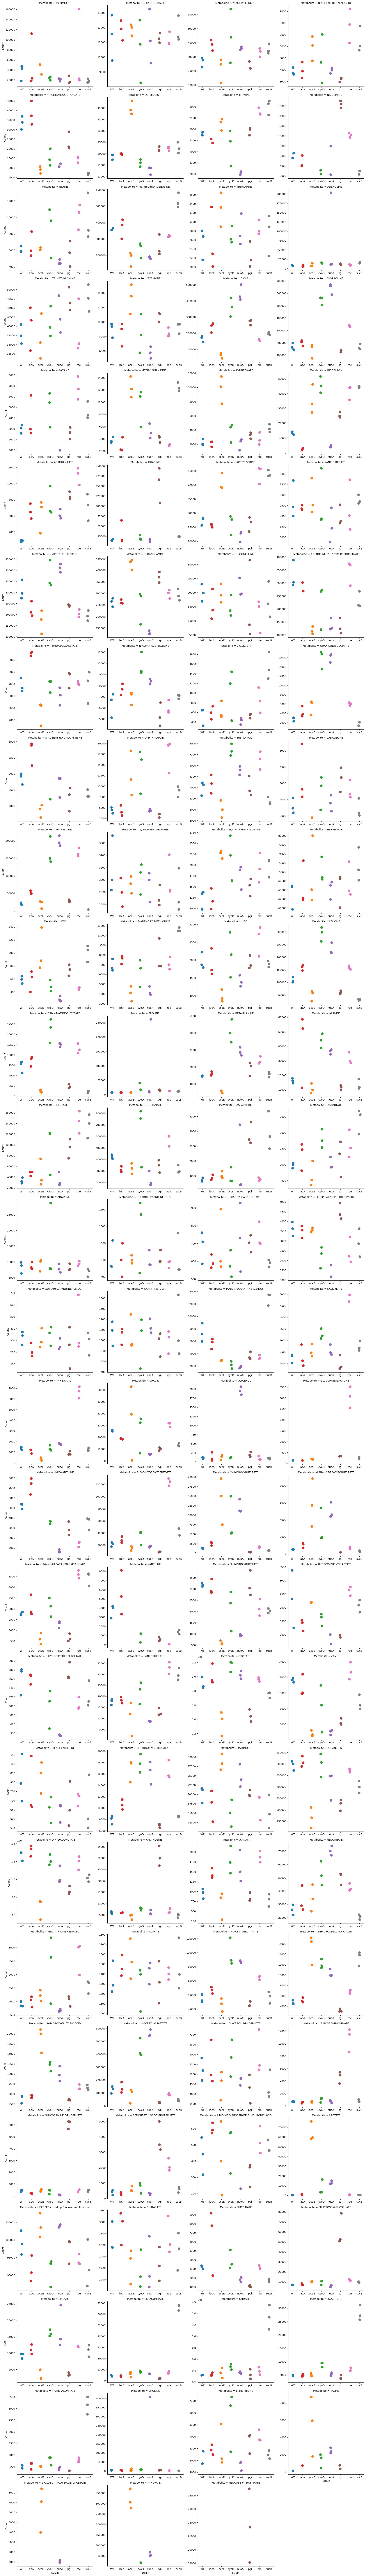

In [42]:
sns.catplot(data=df.loc[df.Count>1], x = 'Strain', y = 'Count', col='Metabolite', col_wrap=4, sharey=False, hue = 'Strain', sharex = False,  order=['WT', 'lacA', 'aceE', 'cyoD', 'nuoA', 'pgi', 'rpe', 'sucB'], s = 100) #log_scale=True,

In [16]:
count_df.set_index('Metabolite', inplace=True)

In [17]:
X = StandardScaler().fit_transform(count_df.T)

In [18]:
pca = PCA(n_components=3)

In [19]:
pca.fit(X)
Xn = pca.transform(X)

In [20]:
pca.explained_variance_ratio_

array([0.20824866, 0.19216155, 0.15184717])

In [21]:
set(id_mapping.values())

{'11A-2: WT',
 '11B-2: WT',
 '11C-2: WT',
 '12A-1: pool',
 '12B-1: pool',
 '12C-1: pool',
 '1A-2: aceE',
 '1B-2: aceE',
 '1C-2: aceE',
 '2A-2: cyoD',
 '2B-2: cyoD',
 '2C-2: cyoD',
 '3A-2: lacA',
 '3B-2: lacA',
 '3C-2: lacA',
 '4A-2: nuoA',
 '4B-2: nuoA',
 '4C-2: nuoA',
 '5A-2: pgi',
 '5B-2: pgi',
 '5C-2: pgi',
 '6A-2: rpe',
 '6B-2: rpe',
 '6C-2: rpe',
 '8A-2: sucB',
 '8B-2: sucB',
 '8C-2: sucB'}

In [35]:
var = pca.explained_variance_ratio_
pca_df = pd.DataFrame(Xn, columns=[f'Principal component 1 ({var[0]*100:.1f}%)', f'Principal component 2 ({var[1]*100:.1f}%)', 'Principal component 3'])

In [36]:
pca_df['Sample'] = [id_mapping[sample] for sample in count_df.columns]
pca_df['Strain'] = [x.split(': ')[1] for x in pca_df['Sample']]

In [37]:
pca_df

,Principal component 1 (20.8%),Principal component 2 (19.2%),Principal component 3,Sample,Strain
0,0.151073,-1.979851,-3.273586,11A-2: WT,WT
1,-1.052126,-1.936041,-3.522763,11B-2: WT,WT
2,-1.058105,-1.389816,-3.294529,11C-2: WT,WT
3,9.457761,0.064627,5.804729,1A-2: aceE,aceE
4,11.647790,-1.623850,3.113386,1B-2: aceE,aceE
5,9.321107,0.010712,6.361973,1C-2: aceE,aceE
6,-6.333666,3.458094,4.020814,2A-2: cyoD,cyoD
7,-5.083996,4.254862,2.768912,2B-2: cyoD,cyoD
8,-1.117567,7.288006,0.488255,2C-2: cyoD,cyoD
9,-2.512457,-0.989311,-3.539826,3A-2: lacA,lacA


<Axes: xlabel='Principal component 1 (20.8%)', ylabel='Principal component 2 (19.2%)'>

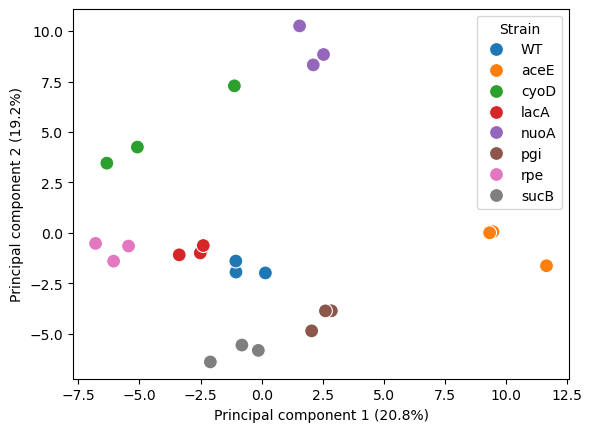

In [38]:
sns.scatterplot(data = pca_df, x = f'Principal component 1 ({var[0]*100:.1f}%)', y = f'Principal component 2 ({var[1]*100:.1f}%)', hue = 'Strain', s = 100)

<Axes: xlabel='Principal component 1', ylabel='Principal component 3'>

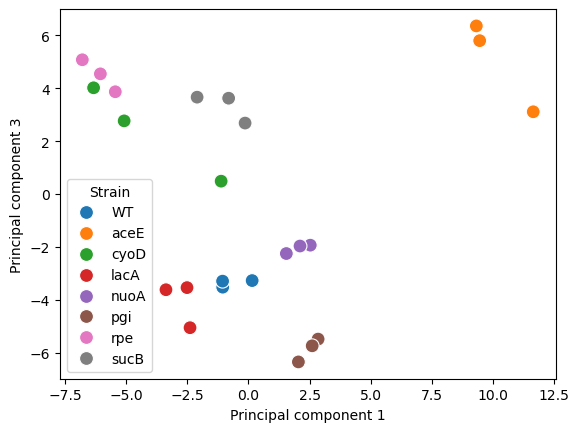

In [26]:
sns.scatterplot(data = pca_df, x = 'Principal component 1', y = 'Principal component 3', hue = 'Strain', s = 100)

In [27]:
pca.components_

array([[-0.03603235,  0.03593583, -0.12182701, -0.04535609, -0.06178398,
         0.13683752, -0.02550427, -0.04570707, -0.13158451, -0.09627395,
         0.07040534,  0.01230505,  0.00511265,  0.01590903,  0.09847667,
        -0.05078835, -0.06322359, -0.17436348,  0.07883101,  0.14209093,
        -0.01814673, -0.0746827 ,  0.02342113,  0.00427871, -0.00953166,
        -0.03743532,  0.08088103, -0.07521269,  0.05487127, -0.15618357,
        -0.12751206, -0.0425494 , -0.07518288, -0.0260191 ,  0.02857557,
        -0.0518735 , -0.14462734, -0.11028473, -0.08029955, -0.02423353,
         0.02439678, -0.00386885,  0.09424536, -0.1046203 , -0.17308012,
        -0.10297954, -0.1291838 ,  0.0037372 ,  0.14019422, -0.12764349,
        -0.11095913, -0.10662529, -0.12323635,  0.02735254, -0.11323482,
        -0.04103371, -0.04430757,  0.02636627,  0.04301022, -0.03528987,
         0.00478542, -0.03533051, -0.11473578, -0.1211579 , -0.0167143 ,
         0.03676484,  0.16871421, -0.0908459 , -0.1

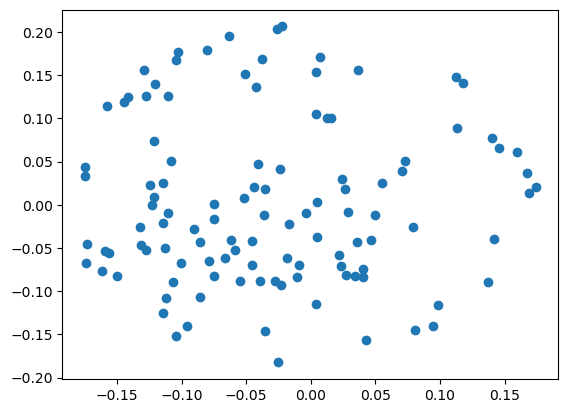

In [25]:
plt.scatter(pca.components_[0, :], pca.components_[1, :])

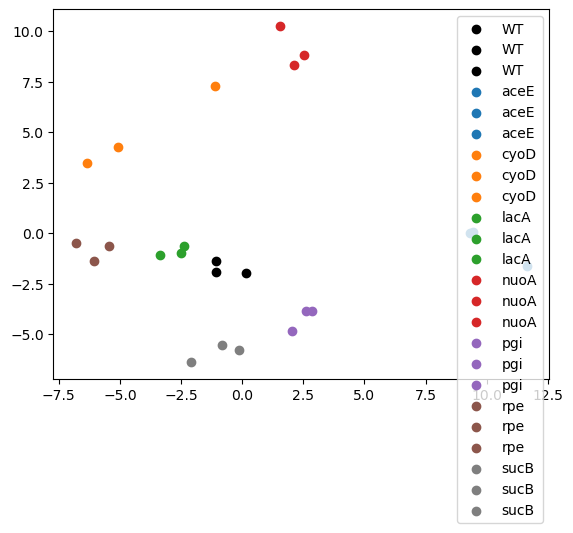

In [26]:
fig, ax =  plt.subplots(1)
for i, sample in enumerate(count_df.columns):
    sample_id = id_mapping[sample]
    strain = sample_id.split(': ')[1]
    j = int(re.search(r'\d+', sample_id).group())
    if strain == 'WT':
        ax.scatter(Xn[i,0], Xn[i, 1], label = strain, c = 'k')
    else:
        ax.scatter(Xn[i,0], Xn[i, 1], label = strain, c = f'C{j-1}')
    plt.legend()
    

In [73]:
id_mapping

{'SR_MPTA_020204_11A-2_WT_22': '11A-2: WT',
 'SR_MPTA_020204_11B-2_WT_23': '11B-2: WT',
 'SR_MPTA_020204_11C-2_WT_24': '11C-2: WT',
 'SR_MPTA_020204_12A-1_pool_A_25': '12A-1: pool',
 'SR_MPTA_020204_12B-1_pool_B_26': '12B-1: pool',
 'SR_MPTA_020204_12C-1_pool_C_27': '12C-1: pool',
 'SR_MPTA_020204_1A-2_aceE_1': '1A-2: aceE',
 'SR_MPTA_020204_1B-2_aceE_2': '1B-2: aceE',
 'SR_MPTA_020204_1C-2_aceE_3': '1C-2: aceE',
 'SR_MPTA_020204_2A-2_cyoD_4': '2A-2: cyoD',
 'SR_MPTA_020204_2B-2_cyoD_5': '2B-2: cyoD',
 'SR_MPTA_020204_2C-2_cyoD_6': '2C-2: cyoD',
 'SR_MPTA_020204_3A-2_lacA_7': '3A-2: lacA',
 'SR_MPTA_020204_3B-2_lacA_8': '3B-2: lacA',
 'SR_MPTA_020204_3C-2_lacA_9': '3C-2: lacA',
 'SR_MPTA_020204_4A-2_nuoA_10': '4A-2: nuoA',
 'SR_MPTA_020204_4B-2_nuoA_11': '4B-2: nuoA',
 'SR_MPTA_020204_4C-2_nuoA_12': '4C-2: nuoA',
 'SR_MPTA_020204_5A-2_pgi_13': '5A-2: pgi',
 'SR_MPTA_020204_5B-2_pgi_14': '5B-2: pgi',
 'SR_MPTA_020204_5C-2_pgi_15': '5C-2: pgi',
 'SR_MPTA_020204_6A-2_rpe_16': '6A-2: rpe',

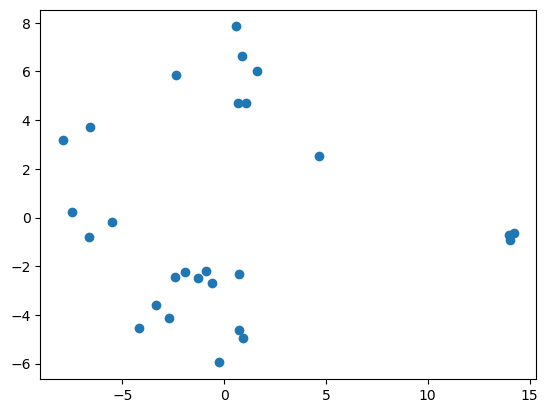

In [69]:
plt.scatter(Xn[:,0], Xn[:,1])